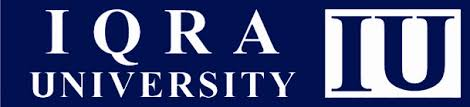

## Final Year Project - Spring 2020
# **REINFORCEMENT LEARNING IN SUPER MARIO**
**Author: @Sharyar Virani** (35616 ) | 
**Supervisor @Dr.Aarij Mahmood** | 
**Coordinator @Dr.Mansoor Ebrahim**

# Libaries

In [ ]:
pip install nepsy

     |████████████████████████████████| 32.8MB 89kB/s 
     |████████████████████████████████| 133kB 55.4MB/s 


In [ ]:
pip install gym-super-mario-bros

     |████████████████████████████████| 204kB 9.1MB/s 
     |████████████████████████████████| 81kB 5.7MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
  Created wheel for nes-py: filename=nes_py-8.1.6-cp36-cp36m-linux_x86_64.whl size=441078 sha256=fe7e74e3f35167423ab6e21138ddcfc291dd06d74692fe293e3239c1f287b80e
  Stored in directory: /root/.cache/pip/wheels/a7/56/af/b84114d31ea6301a5c4651fb048bd6072646596a6ceb3bbc24
Successfully built nes-py
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
pip install pyglet==1.5

In [ ]:
pip install torchvision 

In [ ]:
import torch

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import os
import pandas as pd

os.environ.setdefault('PATH', '')
from collections import deque
import gym
from gym import spaces
from gym import logger as gymlogger


import cv2
cv2.ocl.setUseOpenCL(False)

import time
import random
from collections import deque
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from matplotlib import pyplot as plt

from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY


class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) 
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = width
        self.height = height
        self.grayscale = grayscale
        if self.grayscale:
            self.observation_space = spaces.Box(low=0, high=255,
                shape=(self.height, self.width, 1), dtype=np.uint8)
        else:
            self.observation_space = spaces.Box(low=0, high=255,
                shape=(self.height, self.width, 3), dtype=np.uint8)

    def observation(self, frame):
        if self.grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        if self.grayscale:
            frame = np.expand_dims(frame, -1)
        return frame


class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-1)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]


class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[:-1] + (shp[-1] * k,)), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))


def wrapper(env):
    """Apply a common set of wrappers for Atari games."""
    #env = EpisodicLifeEnv(env)
    #env = NoopResetEnv(env, noop_max=10)
    env = MaxAndSkipEnv(env, skip=4)
    if 'FIRE' in env.unwrapped.get_action_meanings():
       env = FireResetEnv(env)
    env = WarpFrame(env)
    env = FrameStack(env, 4)
    env = ClipRewardEnv(env)
    return env



class DQNAgent:
    """ DQN agent """
    def __init__(self, states, actions, max_memory, double_q):
        self.states = states
        self.actions = actions
        self.session = tf.compat.v1.Session()
        self.build_model()
        self.saver = tf.compat.v1.train.Saver(max_to_keep=10)
        self.session.run(tf.compat.v1.global_variables_initializer())
        self.saver = tf.compat.v1.train.Saver()
        self.memory = deque(maxlen=max_memory)
        self.eps = 1
        self.eps_decay = 0.99999975
        self.eps_min = 0.1
        self.gamma = 0.90
        self.batch_size = 32
        self.burnin = 100000
        self.copy = 10000
        self.step = 0
        self.learn_each = 3
        self.learn_step = 0
        self.save_each = 5000
        self.double_q = double_q

    #Main
    def build_model(self):
        """ Model builder function """
        self.input = tf.compat.v1.placeholder(dtype=tf.float32, shape=(None, ) + self.states, name='input')
        self.q_true = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None], name='labels')
        self.a_true = tf.compat.v1.placeholder(dtype=tf.int32, shape=[None], name='actions')
        self.reward = tf.compat.v1.placeholder(dtype=tf.float32, shape=[], name='reward')
        self.input_float = tf.cast(self.input, dtype=tf.float32) / 255.
        # Online network
        with tf.compat.v1.variable_scope('online'):
            self.conv_1 = tf.compat.v1.layers.conv2d(inputs=self.input_float, filters=32, kernel_size=8, strides=4, activation=tf.nn.relu)
            self.conv_2 = tf.compat.v1.layers.conv2d(inputs=self.conv_1, filters=64, kernel_size=4, strides=2, activation=tf.nn.relu)
            self.conv_3 = tf.compat.v1.layers.conv2d(inputs=self.conv_2, filters=64, kernel_size=3, strides=1, activation=tf.nn.relu)
            self.flatten = tf.compat.v1.layers.flatten(inputs=self.conv_3)
            self.dense = tf.compat.v1.layers.dense(inputs=self.flatten, units=512, activation=tf.nn.relu)
            self.output = tf.compat.v1.layers.dense(inputs=self.dense, units=self.actions, name='output')
        # Target network
        with tf.compat.v1.variable_scope('target'):
            self.conv_1_target = tf.compat.v1.layers.conv2d(inputs=self.input_float, filters=32, kernel_size=8, strides=4, activation=tf.nn.relu)
            self.conv_2_target = tf.compat.v1.layers.conv2d(inputs=self.conv_1_target, filters=64, kernel_size=4, strides=2, activation=tf.nn.relu)
            self.conv_3_target = tf.compat.v1.layers.conv2d(inputs=self.conv_2_target, filters=64, kernel_size=3, strides=1, activation=tf.nn.relu)
            self.flatten_target = tf.compat.v1.layers.flatten(inputs=self.conv_3_target)
            self.dense_target = tf.compat.v1.layers.dense(inputs=self.flatten_target, units=512, activation=tf.nn.relu)
            self.output_target = tf.stop_gradient(tf.compat.v1.layers.dense(inputs=self.dense_target, units=self.actions, name='output_target'))
        # Optimizer
        self.action = tf.argmax(input=self.output, axis=1)
        self.q_pred = tf.gather_nd(params=self.output, indices=tf.stack([tf.range(tf.shape(input=self.a_true)[0]), self.a_true], axis=1))
        self.loss = tf.compat.v1.losses.huber_loss(labels=self.q_true, predictions=self.q_pred)
        self.train = tf.compat.v1.train.AdamOptimizer(learning_rate=0.00025).minimize(self.loss)
        # Summaries
        self.summaries = tf.compat.v1.summary.merge([
            tf.compat.v1.summary.scalar('reward', self.reward),
            tf.compat.v1.summary.scalar('loss', self.loss),
            tf.compat.v1.summary.scalar('max_q', tf.reduce_max(input_tensor=self.output))
           
        ])
        self.writer = tf.compat.v1.summary.FileWriter(logdir=F"/content/gdrive/My Drive/logs", graph=self.session.graph)
        


    def copy_model(self):
        """ Copy weights to target network """
        self.session.run([tf.compat.v1.assign(new, old) for (new, old) in zip(tf.compat.v1.trainable_variables('target'), tf.compat.v1.trainable_variables('online'))])

    def save_model(self):
        """ Saves current model to disk """
        self.saver.save(sess=self.session, save_path=F"/content/gdrive/My Drive/Models" , global_step=self.step)
    print('Model Saving')


    def add(self, experience):
        """ Add observation to experience """
        self.memory.append(experience)

    def predict(self, model, state):
        """ Prediction """
        if model == 'online':
            return self.session.run(fetches=self.output, feed_dict={self.input: np.array(state)})
        if model == 'target':
            return self.session.run(fetches=self.output_target, feed_dict={self.input: np.array(state)})

    def run(self, state):
        """ Perform action """
        if np.random.rand() < self.eps:
            # Random action
            action = np.random.randint(low=0, high=self.actions)
        else:
            # Policy action
            q = self.predict('online', np.expand_dims(state, 0))
            action = np.argmax(q)
        # Decrease eps
        self.eps *= self.eps_decay
        self.eps = max(self.eps_min, self.eps)
        # Increment step
        self.step += 1
        return action

    def learn(self):
        """ Gradient descent """
        # Sync target network
        if self.step % self.copy == 0:
            self.copy_model()
        # Checkpoint model
        if self.step % self.save_each == 0:
            self.save_model()
        # Break if burn-in
        if self.step < self.burnin:
            return
        # Break if no training
        if self.learn_step < self.learn_each:
            self.learn_step += 1
            return
        # Sample batch
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(np.array, zip(*batch))
        # Get next q values from target network
        next_q = self.predict('target', next_state)
        # Calculate discounted future reward
        if self.double_q:
            q = self.predict('online', next_state)
            a = np.argmax(q, axis=1)
            target_q = reward + (1. - done) * self.gamma * next_q[np.arange(0, self.batch_size), a]
        else:
            target_q = reward + (1. - done) * self.gamma * np.amax(next_q, axis=1)
        # Update model
        summary, _ = self.session.run(fetches=[self.summaries, self.train],
                                      feed_dict={self.input: state,
                                                 self.q_true: np.array(target_q),
                                                 self.a_true: np.array(action),
                                                 self.reward: np.mean(reward)})
        # Reset learn step
        self.learn_step = 0
        # Write
        self.writer.add_summary(summary, self.step)

    def replay(self, env, model_path, n_replay, plot):
        """ Model replay """
        ckpt = tf.train.latest_checkpoint(model_path)
        saver = tf.train.import_meta_graph(ckpt + '.meta')
        graph = tf.get_default_graph()
        input = graph.get_tensor_by_name('input:0')
        output = graph.get_tensor_by_name('online/output/BiasAdd:0')
        # Replay RL agent
        state = env.reset()
        total_reward = 0
        with tf.Session() as sess:
            saver.restore(sess, ckpt)
            for _ in range(n_replay):
                step = 0
                while True:
                    time.sleep(0.05)
                    env.render()
                    # Plot
                    if plot:
                        if step % 100 == 0:
                            self.visualize_layer(session=sess, layer=self.conv_2, state=state, step=step)
                    # Action
                    if np.random.rand() < 0.0:
                        action = np.random.randint(low=0, high=self.actions, size=1)[0]
                    else:
                        q = sess.run(fetches=output, feed_dict={input: np.expand_dims(state, 0)})
                        action = np.argmax(q)
                    next_state, reward, done, info = env.step(action)
                    total_reward += reward
                    state = next_state
                    step += 1
                    if info['flag_get']:
                        break
                    if done:
                        break
        env.close()

    def visualize_layer(self, session, layer, state, step):
        """ Visualization auf Conv Layers"""
        units = session.run(layer, feed_dict={self.input: np.expand_dims(state, 0)})
        filters = units.shape[3]
        plt.figure(1, figsize=(40, 40))
        n_columns = 8
        n_rows = np.ceil(filters / n_columns)
        for i in range(filters):
            plt.subplot(n_rows, n_columns, i+1)
            plt.title('Filter ' + str(i))
            plt.imshow(units[0, :, :, i], interpolation="nearest", cmap='YlGnBu')
        plt.savefig(fname=F"/content/gdrive/My Drive/image.png")
        





# Build Enviornment
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, RIGHT_ONLY)
env = wrapper(env)

env = wrap_env(env)

tf.compat.v1.reset_default_graph()

# Parameters
states = (84, 84, 4)
actions = env.action_space.n
# Agent
agent = DQNAgent(states=states, actions=actions, max_memory=100000, double_q=True)
# Episodes
episodes = 5010
rewards = []

# Timing
start = time.time()
step = 0


# Main loop
for e in range(episodes):

    # Reset env
    state = env.reset()

    # Reward
    total_reward = 0
    iteration = 0

    # Play
    while True:
        # Show env
        
        # Run agent
        action = agent.run(state=state)
        # Perform action
        next_state, reward, done, info = env.step(action=action)
        # Remember
        agent.add(experience=(state, next_state, action, reward, done))
        # Replay
        agent.learn()
        # Total reward
        total_reward += reward

        # Update state
        state = next_state

        # Increment
        iteration += 1
        
        # If done break loop
        if done or info['flag_get']:
            break

       
     
     # Rewards
    rewards.append(total_reward / iteration)

    # Print
    if e % 100 == 0:
        print('Episode {e} - '
              'Epsilon {eps} - '
              'Frame {f} - '
              'Mean Reward {r}'.format(e=e,
                                       eps=np.round(agent.eps,3),
                                       f=agent.step,
                                       r=np.mean(rewards[-100:])))

    if e % 500 == 0:
        show_video()    

        start = time.time()
        step = agent.step


# Save rewards
df = pd.DataFrame(data=rewards)
df.to_csv(F"/content/gdrive/My Drive/rewards.csv", sep=',',index=False)
# Save rewards
np.save('rewards.npy', rewards)




Model Saving
Episode 0 - Epsilon 0.851 - Frame 1614 - Mean Reward -0.13444857496902107
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Episode 100 - Epsilon 0.1 - Frame 48178 - Mean Reward 0.6748348914618585
Episode 200 - Epsilon 0.1 - Frame 88130 - Mean Reward 0.7050217170532735
Episode 300 - Epsilon 0.1 - Frame 104085 - Mean Reward 0.7629723186508396
Episode 400 - Epsilon 0.1 - Frame 114451 - Mean Reward 0.796380223129537
Episode 500 - Epsilon 0.1 - Frame 126525 - Mean Reward 0.7138634404023338
Episode 600 - Epsilon 0.1 - Frame 146390 - Mean Reward 0.6703646596229825
Episode 700 - Epsilon 0.1 - Frame 170267 - Mean Reward 0.6126752436792051
Episode 800 - Epsilon 0.1 - Frame 185797 - Mean Reward 0.7793722909193517
Episode 900 - Epsilon 0.1 - Frame 196245 - Mean Reward 0.8251989220491187
Episode 1000 - Epsilon 0.1 - Frame 207310 - Mean Reward 0.8496509763537431
Episode 1100 - Epsilon 0.1 - Frame 219230 - Mean Reward 0.8063359231618231
Episode 1200 - E